<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/PrincipiosDeProbabilidad/Semana6/Metropolis_Hastings_para_decifrar_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Algoritmo Metropolis Hastings para decifrar textos <h2>

El presente código es una adaptación del presentado en [este repositorio](https://github.com/svivek/mcmc-decoding-example)

El ejemplo está inspirado en la historia descrita en [The Markov Chain Monte Carlo Revolution](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/S0273-0979-08-01238-X.pdf).







<img src='https://pbs.twimg.com/media/DnJnUCpWwAAmPnR.jpg'>



El objetivo es decifrar los mensajes intercambiados por prisioneros, con la conjetura de que cada simbolo representa una letra o simbolo del lenguaje. La tarea es pues, encontrar ese diccionario o **clave** para codificar y decodificar los mensajes.

# Bibliotecas y Funciones

In [1]:
import re
from collections import Counter
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def limpiar_texto(texto):

    #cambiar texto a minusculas
    texto = texto.lower()

    # quitar tildes
    a,b = 'áéíóúü','aeiouu'
    trans = str.maketrans( a,b)
    texto = texto.translate(trans)

    # solo letras y numeros
    texto = re.sub('[^ña-z0-9 ]+' ,' ', texto).strip()

    # remplazar multiples espacios contiguos por un solo espacio
    texto = re.sub('\s+',' ', texto)
    return texto

def find_between( s, first, last ):
    '''fuente: https://stackoverflow.com/questions/3368969/find-string-between-two-substrings'''
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
def leer_texto(file, inicio=None, fin=None):
    with open(file, 'r') as f:
        if inicio is not None and fin is not None:
            libro = find_between(f.read(), inicio, fin)
        else:
            libro = f.read()
    return limpiar_texto(libro)

In [3]:
def bigram_log_probabilities(book):

    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    return dict(map(lambda k: [k, math.log(bigram_counts[k]) - math.log(character_counts[k[0]])], bigrams))

In [4]:
LOG_EPSILON = -30  # probabilidad muy pequeña vista como logaritmo, que se usará
                   # cuando no exista probabilidad de transición de una letra a otra

def goodness(text, bigram_table):
    bigrams = zip(text, text[1:])
    sum = 0
    for b in bigrams:
        sum += bigram_table.get(b) or LOG_EPSILON
    return sum

In [5]:
def MatrizTransisionLetras(book):

    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    MT = pd.DataFrame(LOG_EPSILON,
                      index = [ch for ch in alphabet],
                      columns =  [ch for ch in alphabet],
                      dtype=float)
    for row, col in bigrams:
        MT.loc[row, col] = math.log(bigram_counts[(row, col)]) - math.log(character_counts[row])

    fig = plt.figure(figsize = (25, 20))
    ax = sns.heatmap(np.exp(MT),
                     cmap = "mako_r",
                     cbar = False,
                     annot = True,
                     fmt=".2f",
                     square = True)
    ax.xaxis.tick_top()
    plt.show()

## Cifrado por sustitución

Es un método de cifrado para codificar y decodificar mensajes usando una clave que relaciona una letra o simbolo por otro.

Como ejemplo, se puede suponer que la clave de un cifrado está contenida en la siguiente tabla:

|original | codificado |
|---------|------------|
|a        | z          |
|n        | 4          |
|l        | 5          |
|i        | a          |
|s        | 8          |

De manera que la palabra  `analisis` puede ser codificada como `z4z5a8a8`.

In [6]:
def code(text, key):
    return ''.join(list(map(lambda char: key[char], text)))

In [7]:
clave = {'a': 'z', 'n': '4', 'l': '5', 'i': 'a', 's':'8'}
code('analisis', clave)

'z4z5a8a8'

Y podemos decodificar la palabra usando la clave inversa:

In [8]:
inv_clave = {v : k for k, v in clave.items()}
code('z4z5a8a8', inv_clave)

'analisis'

#¿Cómo encontrar una clave adecuada?

Si consideramos solamente el espacio en blanco, las letras en minúscula, y los números estamos hablando de 38 simbolos, y por tanto el espacio muestral en el que vive la clave es enorme.

In [9]:
alphabet = "abcdefghijklmnñopqrstuvwxyz0123456789 "

print('Total de simbolos considerados:', len(alphabet))

from math import factorial
print('Tamaño del espacio muestral en el que vive la clave que buscamos', factorial(38))

Total de simbolos considerados: 38
Tamaño del espacio muestral en el que vive la clave que buscamos 523022617466601111760007224100074291200000000


Supondremos que el lenguaje de los mensajes cifrados es el español, por tanto utilizaremos como guía las probabilidades de transición de los carácteres en español.

# ¿Cómo obtener la matriz de transición de los caracteres?


Para aprender estas probabilidades usaremos un texto, lo más largo posible en español

Se puede calcular las probabilidades de transisión utilizando cualquier texto. Si este es suficientemente grande, podremos obtener buenas estimaciones. Usaremos Don Quijote de la Mancha, que tiene más de 2 millones de caracteres.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
inicio = "*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"
fin = "*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"

file = '/content/drive/MyDrive/Datos/DonQuijote.txt'
DonQ = leer_texto(file, inicio, fin )

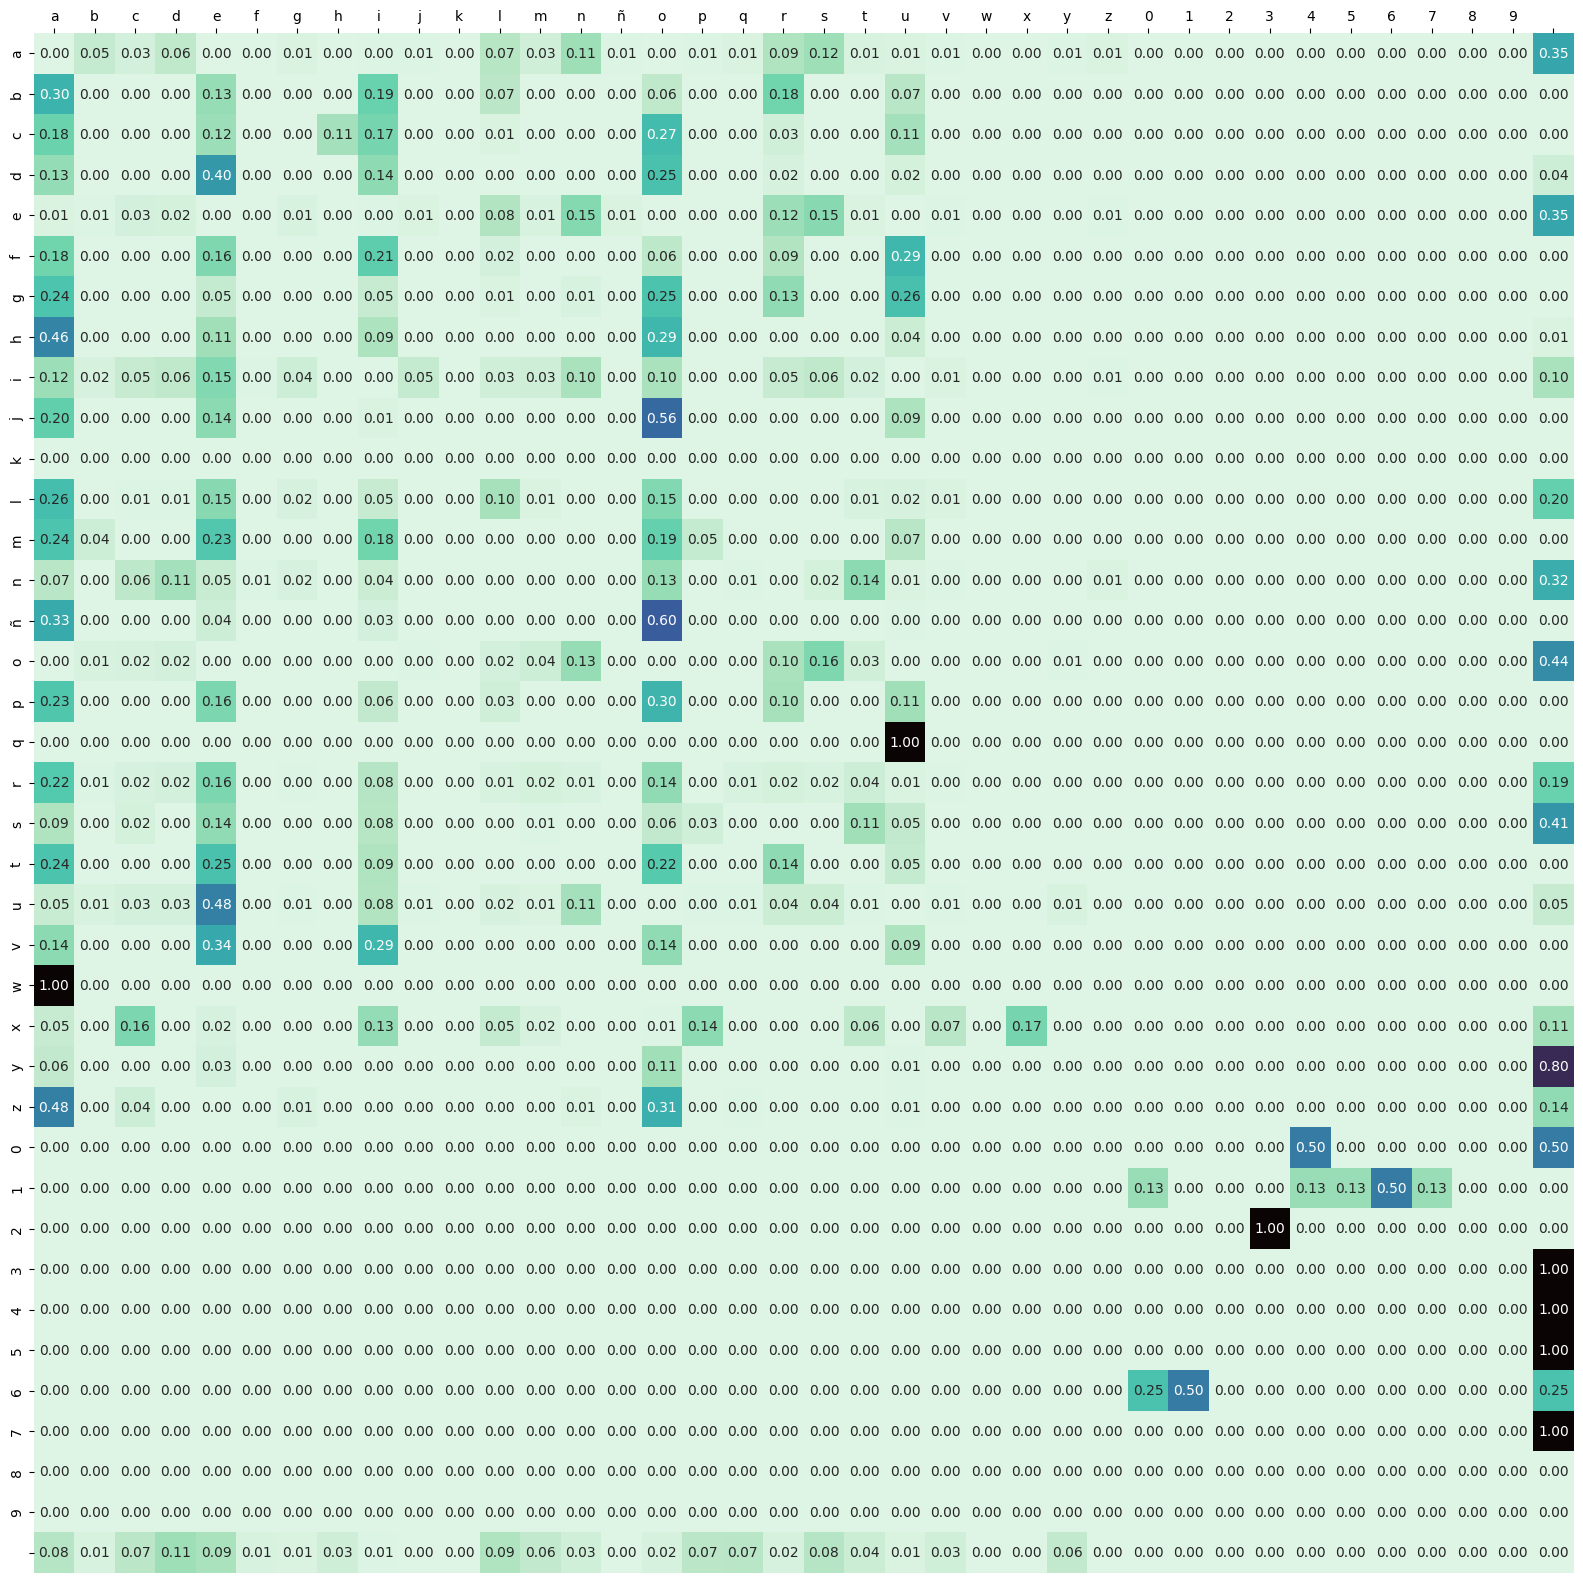

In [12]:
 MatrizTransisionLetras(DonQ)

# Calificación de las claves candidatas

Para cada secuencia de caracteres $c_1c_2c_3\cdots c_n$, estimaresmos su probabilidad de la siguiente manera

$$P(c_1c_2c_3\cdots c_n) = P(c_1) P(c_2 \mid c_1) P(c_3 \mid c_2) \cdots P(c_n \mid c_{n-1})$$

Así, la probabilidad de la palabra `analisis` se calcularía como

 $P(a)~P(n \mid a)P(a \mid n)P(l \mid a)P(i \mid l)P(s \mid i)P(i \mid s)P(s \mid i)$.

Para hacer lo anterior necesitamos una matriz de transición de un caracter a otro, y en este sentido, para facilitar el análisis,  ignoraremos el primer caracter porque no hará practicamente diferencia en una secuencia larga.

Mediante la función "goodness", valiendonos de las probabilidades de la matriz de transisión de caracteres en español,  compararemos las secuencias decodificadas para ver con cual clave se produce una secuencia más plausible.

In [14]:
print("Log probability of 'opamc' = ",goodness("opamc", bigram_table))

Log probability of 'opamc' =  -40.784560457172915


In [15]:
print("Log probabilidad de 'campo' = " +str(goodness("campo", bigram_table)))

Log probabilidad de 'campo' = -9.40201613643682


# Implementación

## Creación del mensaje encriptado

In [16]:
plain_text = limpiar_texto(
    """Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de
barba montaraz y manos de gorrión, que se presentó con el nombre de Melquíades, hizo una
truculenta demostración pública de lo que él mismo llamaba la octava maravilla de los sabios
alquimistas de Macedonia. Fue de casa en casa arrastrando dos lingotes metálicos, y todo el
mundo se espantó al ver que los calderos, las pailas, las tenazas y los anafes se caían de su sitio,
y las maderas crujían por la desesperación de los clavos y los tornillos tratando de desenclavarse,
y aun los objetos perdidos desde hacía mucho tiempo aparecían por donde más se les había
buscado, y se arrastraban en desbandada turbulenta detrás de los fierros mágicos de Melquíades.
"""
)

In [17]:
import random

def make_random_key():
    l = list(alphabet)
    random.shuffle(l)
    return dict(zip(alphabet, l))

In [18]:
key = make_random_key()
cipher_text = code(plain_text, key)
cipher_text

'2añ7qgsvpqgsjhgwahgsxlhfdhsv3swh3qdqfsjhsxagt3v2thfdqsh3sñqlqfh3svalh3tvfqsrahfjtvs7vrtvsjhslhñqljvlsvkah33vsdvljhslh2qdvshfskahsgaswvjlhs3qs33h9qsvsñqfqñhlsh3s7th3qs2vñqfjqshlvshfdqfñhgsafvsv3jhvsjhs9htfdhsñvgvgsjhsrvllqsisñvpvrlv9vsñqfgdlatjvgsvs3vsqlt33vsjhsafsltqsjhsvoavgsjtvxvfvgskahsghswlhñtwtdvrvfswqlsafs3hñ7qsjhswthjlvgswa3tjvgsr3vfñvgsishfql2hgsñq2qs7ah9qgswlh7tgdqltñqgsh3s2afjqshlvsdvfslhñthfdhskahs2añ7vgsñqgvgsñvlhñtvfsjhsfq2rlhsiswvlvs2hfñtqfvl3vgs7vrtvskahsghpv3vltvgsñqfsh3sjhjqsdqjqgs3qgsvpqgswqlsh3s2hgsjhs2vl8qsafvsxv2t3tvsjhsotdvfqgsjhgvllvwvjqgsw3vfdvrvsgasñvlwvsñhlñvsjhs3vsv3jhvsisñqfsafsolvfjhsv3rqlqdqsjhswtdqgsisdt2rv3hgsjvrvfsvsñqfqñhls3qgsfah9qgstf9hfdqgswlt2hlqs33h9vlqfsh3st2vfsafsotdvfqsñqlwa3hfdqsjhsrvlrvs2qfdvlv8sis2vfqgsjhsoqlltqfskahsghswlhghfdqsñqfsh3sfq2rlhsjhs2h3katvjhgs7t8qsafvsdlaña3hfdvsjh2qgdlvñtqfswar3tñvsjhs3qskahsh3s2tg2qs33v2vrvs3vsqñdv9vs2vlv9t33vsjhs3qgsgvrtqgsv3kat2tgdvgsjhs2vñhjqftvsxahsjhsñvgvshfsñvgvsvllvgdlvfjqsjqgs3tfoqdhgs2hdv3tñqgsisdqj

## Busqueda de la clave

Empezaremos la busqueda de la clave adecuado, utilizando en el inicio una **clave** aleatoria que iremos cambiando por una  clave cercana, simplemente transponiendo dos caracteres seleccionados aleatoriamente.

In [19]:
clave0 = make_random_key()  # creamos una clave inicial
clave0

{'a': 'c',
 'b': 't',
 'c': 'x',
 'd': 'z',
 'e': 'm',
 'f': 'p',
 'g': 'u',
 'h': 'v',
 'i': '4',
 'j': 'e',
 'k': 'w',
 'l': 'j',
 'm': '5',
 'n': ' ',
 'ñ': '6',
 'o': '9',
 'p': 'o',
 'q': '3',
 'r': 'y',
 's': 'i',
 't': 'a',
 'u': 'q',
 'v': 'g',
 'w': 'ñ',
 'x': 'k',
 'y': 'n',
 'z': '7',
 '0': '0',
 '1': 'r',
 '2': 's',
 '3': 'l',
 '4': 'h',
 '5': 'f',
 '6': '2',
 '7': '8',
 '8': '1',
 '9': 'd',
 ' ': 'b'}

In [20]:
decoded0 =code(cipher_text, clave0) # decodificamos
decoded0

'sc683uigo3uievuñcvuikjvpzvigliñvl3z3pievikcualgsavpz3ivli63j3pvligcjvlagp3iycvpeagi8gyagievijv63jegjigwcvllgizgjevijvs3zgivpiwcviuciñgejvil3illvd3igi63p36vjivli8avl3isg63pe3ivjgivpz3p6vuicpgiglevgievidvapzvi6guguieviygjj3i4i6gogyjgdgi63puzjcaeguigilgi3jallgievicpija3ievig9cguieagkgpguiwcviuviñjv6añazgygpiñ3jicpilv683ieviñavejguiñclaeguiylgp6gui4ivp3jsvui63s3i8cvd3uiñjv8auz3ja63uivliscpe3ivjgizgpijv6avpzviwcvisc68gui63ugui6gjv6agpievip3syjvi4iñgjgisvp6a3pgjlgui8gyagiwcviuvoglgjagui63pivlieve3iz3e3uil3uigo3uiñ3jivlisvuievisgj13icpgikgsalagievi9azgp3uievugjjgñge3uiñlgpzgygiuci6gjñgi6vj6gievilgiglevgi4i63picpi9jgpevigly3j3z3ieviñaz3ui4izasyglvuiegygpigi63p36vjil3uipcvd3uiapdvpz3uiñjasvj3illvdgj3pivliasgpicpi9azgp3i63jñclvpz3ieviygjygis3pzgjg1i4isgp3uievi93jja3piwcviuviñjvuvpz3i63pivlip3syjvievisvlwcagevui8a13icpgizjc6clvpzgievs3uzjg6a3piñcyla6gievil3iwcvivlisaus3illgsgygilgi36zgdgisgjgdallgievil3uiugya3uiglwcasauzguievisg6ve3pagikcvievi6gugivpi6gugigjjguzjgpe3ie3uilap93zvuisvzgla63ui4iz3e

In [21]:
log_p0 = goodness(decoded0, bigram_table)  # evaluamos
log_p0

-22332.663760301937

In [22]:
pair = random.sample(alphabet, 2)
pair[0], pair[1]

('2', '4')

In [23]:
clave0[pair[0]] , clave0[pair[1]]

('s', 'h')

In [24]:
clave1 = clave0.copy()
clave1[pair[0]] = clave0[pair[1]]
clave1[pair[1]] = clave0[pair[0]]
clave1

{'a': 'c',
 'b': 't',
 'c': 'x',
 'd': 'z',
 'e': 'm',
 'f': 'p',
 'g': 'u',
 'h': 'v',
 'i': '4',
 'j': 'e',
 'k': 'w',
 'l': 'j',
 'm': '5',
 'n': ' ',
 'ñ': '6',
 'o': '9',
 'p': 'o',
 'q': '3',
 'r': 'y',
 's': 'i',
 't': 'a',
 'u': 'q',
 'v': 'g',
 'w': 'ñ',
 'x': 'k',
 'y': 'n',
 'z': '7',
 '0': '0',
 '1': 'r',
 '2': 'h',
 '3': 'l',
 '4': 's',
 '5': 'f',
 '6': '2',
 '7': '8',
 '8': '1',
 '9': 'd',
 ' ': 'b'}

In [25]:
decoded1 =code(cipher_text, clave1) # decodificamos
decoded1

'hc683uigo3uievuñcvuikjvpzvigliñvl3z3pievikcualghavpz3ivli63j3pvligcjvlagp3iycvpeagi8gyagievijv63jegjigwcvllgizgjevijvh3zgivpiwcviuciñgejvil3illvd3igi63p36vjivli8avl3ihg63pe3ivjgivpz3p6vuicpgiglevgievidvapzvi6guguieviygjj3i4i6gogyjgdgi63puzjcaeguigilgi3jallgievicpija3ievig9cguieagkgpguiwcviuviñjv6añazgygpiñ3jicpilv683ieviñavejguiñclaeguiylgp6gui4ivp3jhvui63h3i8cvd3uiñjv8auz3ja63uivlihcpe3ivjgizgpijv6avpzviwcvihc68gui63ugui6gjv6agpievip3hyjvi4iñgjgihvp6a3pgjlgui8gyagiwcviuvoglgjagui63pivlieve3iz3e3uil3uigo3uiñ3jivlihvuievihgj13icpgikghalagievi9azgp3uievugjjgñge3uiñlgpzgygiuci6gjñgi6vj6gievilgiglevgi4i63picpi9jgpevigly3j3z3ieviñaz3ui4izahyglvuiegygpigi63p36vjil3uipcvd3uiapdvpz3uiñjahvj3illvdgj3pivliahgpicpi9azgp3i63jñclvpz3ieviygjygih3pzgjg1i4ihgp3uievi93jja3piwcviuviñjvuvpz3i63pivlip3hyjvievihvlwcagevui8a13icpgizjc6clvpzgievh3uzjg6a3piñcyla6gievil3iwcvivlihauh3illghgygilgi36zgdgihgjgdallgievil3uiugya3uiglwcahauzguievihg6ve3pagikcvievi6gugivpi6gugigjjguzjgpe3ie3uilap93zvuihvzgla63ui4iz3e

In [26]:
log_p1 = goodness(decoded1, bigram_table)  # evaluamos
log_p1

-23023.761996417

En base a lo anterior ¿Aceptamos la nueva clave propuesta?

## Algoritmo completo

In [27]:
def transpose_random(key):
    pair = random.sample(alphabet, 2)
    new_key = dict(key)
    new_key[pair[0]] = key[pair[1]]
    new_key[pair[1]] = key[pair[0]]
    return new_key

def decode(cipher_text, bigram_table, iters = 10000, print_every = 1000):
    # 1. inicializamos con una clave aleatoria
    current_key = make_random_key()

    for i in range(0, iters):  # en cada iteración utilizaremos una nueva clave

        # 2. decodificamos la secuencia con la clave
        decoded = code(cipher_text, current_key)

        if i % print_every == 0:
            print(str(i) + "\t" + decoded + "\n")

        # 3. evaluamos la secuencia utilizando el modelo de bigramas
        score = goodness(decoded, bigram_table)

        # 4. proponemos una nueva clave "cercana"
        changed_key = transpose_random(current_key)

        # 5. evaluamos la nueva clave decodificando la secuencia
        changed_score = goodness(code(cipher_text, changed_key), bigram_table)  # evaluamos la secuencia con la nueva clave propuesta

        # 6.1 si la clave propuesta da mejores resultados nos quedamos con ella para la prox iteración
        if changed_score > score:
            current_key = changed_key

        # damos oportunidad proporcional a la relación entre la probabilidad de las dos secuencias evaluadas
        else:
            diff = changed_score - score
            if math.log(random.random())  < diff:
                current_key = changed_key

    decoded = code(cipher_text, current_key)
    print("Final decoded: " + decoded)
    return decoded

In [28]:
decode(cipher_text, bigram_table, 10000)

0	0mt7ix pnix l5xkm5x 2ñ5gd5 ph k5hidig l5 2mx3hp035gdi 5h tiñig5h pmñ5h3pgi rm5gl3p 7pr3p l5 ñ5tiñlpñ psm5hhp dpñl5 ñ50idp 5g sm5 xm kplñ5 hi hh5fi p tigit5ñ 5h 735hi 0ptigli 5ñp 5gdigt5x mgp phl5p l5 f53gd5 tpxpx l5 rpññi 1 tpnprñpfp tigxdñm3lpx p hp iñ3hhp l5 mg ñ3i l5 pampx l3p2pgpx sm5 x5 kñ5t3k3dprpg kiñ mg h5t7i l5 k35lñpx kmh3lpx rhpgtpx 1 5giñ05x ti0i 7m5fix kñ573xdiñ3tix 5h 0mgli 5ñp dpg ñ5t35gd5 sm5 0mt7px tixpx tpñ5t3pg l5 gi0rñ5 1 kpñp 05gt3igpñhpx 7pr3p sm5 x5nphpñ3px tig 5h l5li dilix hix pnix kiñ 5h 05x l5 0pñ6i mgp 2p03h3p l5 a3dpgix l5xpññpkplix khpgdprp xm tpñkp t5ñtp l5 hp phl5p 1 tig mg añpgl5 phriñidi l5 k3dix 1 d30rph5x lprpg p tigit5ñ hix gm5fix 3gf5gdix kñ305ñi hh5fpñig 5h 30pg mg a3dpgi tiñkmh5gdi l5 rpñrp 0igdpñp6 1 0pgix l5 aiññ3ig sm5 x5 kñ5x5gdi tig 5h gi0rñ5 l5 05hsm3pl5x 736i mgp dñmtmh5gdp l50ixdñpt3ig kmrh3tp l5 hi sm5 5h 03x0i hhp0prp hp itdpfp 0pñpf3hhp l5 hix xpr3ix phsm303xdpx l5 0pt5lig3p 2m5 l5 tpxp 5g tpxp pññpxdñpgli lix h3gaid5x 05dph3tix 1 di

'muchos años despues frente al peloton de fusilamiento el coronel aureliano buendia habia de recordar avuella tarde remota en vue su padre lo llejo a conocer el hielo macondo era entonces una aldea de jeinte casas de barro y cañabraja construidas a la orilla de un rio de aguas diafanas vue se precipitaban por un lecho de piedras pulidas blancas y enormes como huejos prehistoricos el mundo era tan reciente vue muchas cosas carecian de nombre y para mencionarlas habia vue señalarias con el dedo todos los años por el mes de marzo una familia de gitanos desarrapados plantaba su carpa cerca de la aldea y con un grande alboroto de pitos y timbales daban a conocer los nuejos injentos primero llejaron el iman un gitano corpulento de barba montaraz y manos de gorrion vue se presento con el nombre de melvuiades hizo una truculenta demostracion publica de lo vue el mismo llamaba la octaja marajilla de los sabios alvuimistas de macedonia fue de casa en casa arrastrando dos lingotes metalicos y tod

# Otros ejemplos

In [29]:
# El principito. Tomado de https://archive.org/stream/ElPrincipitoAntoineDeSaintExupery/El_principito-_Antoine_De_Saint_Exupery_djvu.txt

plain_text = limpiar_texto(
    """Tengo poderosas razones para creer que el planeta del cual venía el principito era
el asteroide B 612. Este asteroide ha sido visto sólo una vez con el telescopio en
1909, por un astrónomo turco.
Este astrónomo hizo una gran demostración de su descubrimiento en un congreso
Internacional de Astronomía. Pero nadie le creyó a causa de su manera de vestir.
Las personas mayores son así. Felizmente para la reputación del asteroide B 612,
un dictador turco impuso a su pueblo, bajo pena de muerte, el vestido a la
europea. Entonces el astrónomo volvió a dar cuenta de su descubrimiento en 1920
y como lucía un traje muy elegante, todo el mundo aceptó su demostración.
"""
)
cipher_text = code(plain_text, key)
cipher_text

'dhfoqswqjhlqgvgslv8qfhgswvlvsñlhhlskahsh3sw3vfhdvsjh3sñav3s9hftvsh3swltfñtwtdqshlvsh3svgdhlqtjhsrsybcshgdhsvgdhlqtjhs7vsgtjqs9tgdqsgq3qsafvs9h8sñqfsh3sdh3hgñqwtqshfsbmumswqlsafsvgdlqfq2qsdalñqshgdhsvgdlqfq2qs7t8qsafvsolvfsjh2qgdlvñtqfsjhsgasjhgñarlt2thfdqshfsafsñqfolhgqstfdhlfvñtqfv3sjhsvgdlqfq2tvswhlqsfvjths3hsñlhiqsvsñvagvsjhsgas2vfhlvsjhs9hgdtls3vgswhlgqfvgs2viqlhgsgqfsvgtsxh3t82hfdhswvlvs3vslhwadvñtqfsjh3svgdhlqtjhsrsybcsafsjtñdvjqlsdalñqst2wagqsvsgaswahr3qsrvnqswhfvsjhs2ahldhsh3s9hgdtjqsvs3vshalqwhvshfdqfñhgsh3svgdlqfq2qs9q39tqsvsjvlsñahfdvsjhsgasjhgñarlt2thfdqshfsbmcusisñq2qs3añtvsafsdlvnhs2aish3hovfdhsdqjqsh3s2afjqsvñhwdqsgasjh2qgdlvñtqf'

In [30]:
decode(cipher_text, bigram_table, 20000)

0	i6ñ5wuyw76jwo9ouj90wñ6ouy9j9ubj66jue86u6muym9ñ6i9u76mub89mut6ña9u6muyjañbayaiwu6j9u6mu9oi6jwa76u4u lku6oi6u9oi6jwa76uz9uoa7wutaoiwuowmwu8ñ9ut60ubwñu6mui6m6obwyawu6ñulf3fuywju8ñu9oijwñwrwui8jbwu6oi6u9oijwñwrwuza0wu8ñ9u5j9ñu76rwoij9bawñu76uo8u76ob84jara6ñiwu6ñu8ñubwñ5j6owuañi6jñ9bawñ9mu76u9oijwñwra9uy6jwuñ97a6um6ubj61wu9ub98o9u76uo8ur9ñ6j9u76ut6oiajum9ouy6jowñ9our91wj6ouowñu9oauc6ma0r6ñi6uy9j9um9uj6y8i9bawñu76mu9oi6jwa76u4u lku8ñu7abi97wjui8jbwuary8owu9uo8uy864mwu49pwuy6ñ9u76ur86ji6u6mut6oia7wu9um9u68jwy69u6ñiwñb6ou6mu9oijwñwrwutwmtawu9u79jub86ñi9u76uo8u76ob84jara6ñiwu6ñulfk3u1ubwrwum8ba9u8ñuij9p6ur81u6m659ñi6uiw7wu6mur8ñ7wu9b6yiwuo8u76rwoij9bawñ

1000	eclgiasincrim mar yilcmas r abrccrajucachash lce anchabu hazclo achasrolbosoeiacr acha mecrioncadañq7acmeca mecrioncaf amoniazomeiamihiaul azcyabilachaechcmbisoiaclaq101asiraula merilitiaeurbiacmeca merilitiafoyiaul agr lanctimer boilancamuancmbudrotocleiaclaulabilgrcmiaolecrl boil hanca merilito ascrial nocahcabrcvia ab um ancamuat lcr 

'eclgiasincrim mar pilcmas r abrccrafucachash lce anchabu hazclo achasrolbosoeiacr acha mecrioncadaq60acmeca mecrioncay amoniazomeiamihiaul azcpabilachaechcmbisoiacla6141asiraula merilitiaeurbiacmeca merilitiayopiaul agr lanctimer boilancamuancmbudrotocleiaclaulabilgrcmiaolecrl boil hanca merilito ascrial nocahcabrcvia ab um ancamuat lcr ancazcmeorah mascrmil mat vircmamila moajchoptclecas r ah arcsue boilancha mecrioncadaq60aulanobe niraeurbiaotsumia amuasucdhiad xiascl ancatucrecachazcmeonia ah acurisc acleilbcmacha merilitiazihzoia an rabucle ancamuancmbudrotocleiacla6104avabitiahubo aulaer xcatuvachcg lecaeiniachatulnia bcseiamuanctimer boil'

In [31]:
# La liebre y la tortuga. Tomado de https://psicologiaymente.com/cultura/fabulas-de-esopo

plain_text = limpiar_texto(
    """Un día una liebre orgullosa y veloz, vió como una tortuga caminaba por el camino y se le acercó. La liebre empezó a burlarse de la lentitud del otro animal y de la longitud de sus patas. Sin embargo, la tortuga le respondió que estaba segura de que a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera.
La liebre, segura de su victoria y considerando el reto imposible de perder, aceptó. Ambos pidieron a la zorra que señalara la meta, a lo que esta aceptó, al igual que al cuervo para que hiciera de juez.
Al llegar el día de la competición, al empezar la carrera la liebre y la tortuga salieron al mismo tiempo. La tortuga avanzaba sin detenerse, pero lentamente.
La liebre era muy veloz, y viendo que sacaba una gran ventaja a la tortuga decidió ir parándose y descansando de vez en cuando. Pero en una de las ocasiones la liebre se quedó dormida. La tortuga, poco a poco, siguió avanzando.
Cuando la liebre despertó, se encontró con que la tortuga estaba a punto de cruzar la meta. Aunque echó a correr fue demasiado tarde y finalmente la tortuga ganó la carrera".
Esta fábula nos enseña que el trabajo duro, la perseverancia, la constancia y el esfuerzo nos llevarán a nuestras metas, aunque sea poco a poco, si no nos rendimos. También nos permite ver cómo la arrogancia, la falta de constancia y el exceso de seguridad en uno mismo nos puede llevar a perder oportunidades y a no alcanzar nuestras metas.
"""
)
cipher_text = code(plain_text, key)
cipher_text

'afsjtvsafvs3thrlhsqloa33qgvsis9h3q8s9tqsñq2qsafvsdqldaovsñv2tfvrvswqlsh3sñv2tfqsisghs3hsvñhlñqs3vs3thrlhsh2wh8qsvsral3vlghsjhs3vs3hfdtdajsjh3sqdlqsvft2v3sisjhs3vs3qfotdajsjhsgagswvdvgsgtfsh2rvloqs3vsdqldaovs3hslhgwqfjtqskahshgdvrvsghoalvsjhskahsvswhgvlsjhs3vsolvfs9h3qñtjvjsjhs3vs3thrlhshlvsñvwv8sjhsovfvl3vshfsafvsñvllhlvs3vs3thrlhsghoalvsjhsgas9tñdqltvsisñqfgtjhlvfjqsh3slhdqst2wqgtr3hsjhswhljhlsvñhwdqsv2rqgswtjthlqfsvs3vs8qllvskahsghpv3vlvs3vs2hdvsvs3qskahshgdvsvñhwdqsv3stoav3skahsv3sñahl9qswvlvskahs7tñthlvsjhsnah8sv3s33hovlsh3sjtvsjhs3vsñq2whdtñtqfsv3sh2wh8vls3vsñvllhlvs3vs3thrlhsis3vsdqldaovsgv3thlqfsv3s2tg2qsdth2wqs3vsdqldaovsv9vf8vrvsgtfsjhdhfhlghswhlqs3hfdv2hfdhs3vs3thrlhshlvs2ais9h3q8sis9thfjqskahsgvñvrvsafvsolvfs9hfdvnvsvs3vsdqldaovsjhñtjtqstlswvlvfjqghsisjhgñvfgvfjqsjhs9h8shfsñavfjqswhlqshfsafvsjhs3vgsqñvgtqfhgs3vs3thrlhsghskahjqsjql2tjvs3vsdqldaovswqñqsvswqñqsgtoatqsv9vf8vfjqsñavfjqs3vs3thrlhsjhgwhldqsghshfñqfdlqsñqfskahs3vsdqldaovshgdvrvsvswafdqsjhsñla8vls3vs2hdvsvafkahshñ7q

In [32]:
decode(cipher_text, bigram_table, 10000)

0	ñrxozuxñrux1zbthbxphnñ11p7uxjx0b1pex0zpxlpmpxñruxaphañnuxlumzrutux2phxb1xlumzrpxjx7bx1bxulbhlpx1ux1zbthbxbm2bepxuxtñh1uh7bxobx1ux1brazañoxob1xpahpxurzmu1xjxobx1ux1prnzañoxobx7ñ7x2uau7x7zrxbmtuhnpx1uxaphañnux1bxhb72prozpx4ñbxb7autux7bnñhuxobx4ñbxux2b7uhxobx1uxnhurx0b1plzouoxobx1ux1zbthbxbhuxlu2uexobxnuruh1uxbrxñruxluhhbhux1ux1zbthbx7bnñhuxobx7ñx0zlaphzuxjxlpr7zobhuropxb1xhbapxzm2p7zt1bxobx2bhobhxulb2apxumtp7x2zozbhprxux1uxephhux4ñbx7bqu1uhux1uxmbauxux1px4ñbxb7auxulb2apxu1xznñu1x4ñbxu1xlñbh0px2uhux4ñbxszlzbhuxobx ñbexu1x11bnuhxb1xozuxobx1uxlpm2bazlzprxu1xbm2beuhx1uxluhhbhux1ux1zbthbxjx1uxaphañnux7u1zbhprxu1xmz7mpxazbm2px1uxaphañnuxu0ureutux7zrxobabrbh7bx2bhpx1braumbrabx1ux1zbthbxbhuxmñjx0b1pexjx0zbropx4ñbx7ulutuxñruxnhurx0brau uxux1uxaphañnuxoblzozpxzhx2uhurop7bxjxob7lur7uropxobx0bexbrxlñuropx2bhpxbrxñruxobx1u7xplu7zprb7x1ux1zbthbx7bx4ñbopxophmzoux1uxaphañnux2plpxux2plpx7znñzpxu0ureuropxlñuropx1ux1zbthbxob72bhapx7bxbrlprahpxlprx4ñbx1uxaphañnuxb7autuxux2ñrapxobxlhñeuhx1uxmbauxuñr4ñbxbls

'un dia una liebre orgullosa y veloz vio como una tortuga caminaba por el camino y se le acerco la liebre empezo a burlarse de la lentitud del otro animal y de la longitud de sus patas sin embargo la tortuga le respondio fue estaba segura de fue a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera la liebre segura de su victoria y considerando el reto imposible de perder acepto ambos pidieron a la zorra fue señalara la meta a lo fue esta acepto al igual fue al cuervo para fue xiciera de juez al llegar el dia de la competicion al empezar la carrera la liebre y la tortuga salieron al mismo tiempo la tortuga avanzaba sin detenerse pero lentamente la liebre era muy veloz y viendo fue sacaba una gran ventaja a la tortuga decidio ir parandose y descansando de vez en cuando pero en una de las ocasiones la liebre se fuedo dormida la tortuga poco a poco siguio avanzando cuando la liebre desperto se encontro con fue la tortuga estaba a punto de cruzar la meta aunfue ecxo